## Prepare for Synthetic QA Generation

In [1]:
# | eval: false
import json
from os import environ
from typing import Literal, Dict
from multiprocessing import Pool, cpu_count
from functools import partial

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import tiktoken
from langchain.globals import set_verbose
from pymongo import MongoClient
from tqdm.notebook import tqdm

from juddges.settings import DATA_PATH

set_verbose(True)

In [2]:
# | eval: false
client = MongoClient(environ["MONGO_URI"])

In [ ]:
# | eval: false
MODEL = "gpt-3.5-turbo"

COST_PER_TOKEN = {
    "gpt-4": 30 / 10**6,
    "gpt-3.5-turbo": 0.5 / 10**6,
}

MAX_TOKENS = {
    "gpt-4": 32_768,
    "gpt-3.5-turbo": 16_385,
}

## Calculate the number of tokens of judgements

In [4]:
# | eval: false
def _count_tokens(doc: dict, encoding: tiktoken.Encoding) -> Dict[str, int]:
    num_tokens = 3 + len(encoding.encode(doc["text"]))  # https://github.com/openai/openai-cookbook/blob/main/examples/How_to_count_tokens_with_tiktoken.ipynb
    return {doc["_id"]: num_tokens}


agg = [
    {"$match": {"text": {"$exists": True}}},
    # {"$sample": {"size": 20}},
]

total_agg_docs = (
    client["juddges"]["judgements"].aggregate(agg + [{"$count": "text"}]).next()["text"]
)
print(f"{total_agg_docs=}")

encoding = tiktoken.encoding_for_model(MODEL)
judgements_num_tokens = {"__encoding": encoding.name, "__total_docs": total_agg_docs}

docs = client["juddges"]["judgements"].aggregate(agg)

partial_prepro_func = partial(_count_tokens, encoding=encoding)
num_processes = cpu_count()
with Pool(processes=num_processes) as pool:
    for p_result in tqdm(pool.imap_unordered(partial_prepro_func, docs), total=total_agg_docs):
        judgements_num_tokens.update(p_result)

total_agg_docs=408423


  0%|          | 0/408423 [00:00<?, ?it/s]

In [5]:
# | eval: false
with open(DATA_PATH / "pl_judgements_num_tokens.json", "w") as f:
    json.dump(judgements_num_tokens, f, indent=2, ensure_ascii=False)

In [6]:
# | eval: false
# with open(DATA_PATH / "pl_judgements_num_tokens.json") as f:
#     judgements_num_tokens = json.load(f)

judgements_num_tokens_df = pd.DataFrame(
    data=(item for item in judgements_num_tokens.items() if not item[0].startswith("__")),
    columns=["_id", "num_tokens"],
)
judgements_num_tokens_df

,_id,num_tokens
0,154505000005127_XVII_AmA_000014_1994_Uz_1994-0...,8018
1,151500000001006_II_AKa_000031_1998_Uz_2013-02-...,15787
2,151500000001006_II_AKa_000043_1999_Uz_1999-04-...,2141
3,151500000001006_II_AKa_000072_1999_Uz_1999-05-...,1766
4,151500000001006_II_AKa_000115_1999_Uz_1999-05-...,3140
...,...,...
408418,152500000000503_I_ACa_000772_2013_Uz_2013-12-0...,13631
408419,152510000004021_VIII_Pa_000098_2023_Uz_2024-01...,21508
408420,153515000002021_IV_U_001848_2023_Uz_2024-02-08...,15223
408421,153000000000503_I_ACa_000424_2021_Uz_2024-01-3...,16380


### Estimate cost of context preprocessing via OpenAI API

In [7]:
# | eval: false
for up_to_tokens in range(4_000, 32_001, 4_000):
    agg_docs = judgements_num_tokens_df[judgements_num_tokens_df["num_tokens"] <= up_to_tokens]
    estimated_cost = agg_docs["num_tokens"].sum() * COST_PER_TOKEN[MODEL]
    print(
        f"total docs {len(agg_docs):<10,} up to {up_to_tokens:<6,} tokens \t context estimated_cost: ${estimated_cost:,.2f}"
    )

over32_docs = judgements_num_tokens_df[judgements_num_tokens_df["num_tokens"] > 32_000]
over32_estimated_cost = over32_docs["num_tokens"].sum() * COST_PER_TOKEN[MODEL]
print(
    f"total docs {len(agg_docs):<10,} over {32_000:<6,} tokens \t context estimated_cost: ${over32_estimated_cost:,.2f}"
)

all_docs_estimated_cost = judgements_num_tokens_df["num_tokens"].sum() * COST_PER_TOKEN[MODEL]
print(
    f"\nAll the docs {len(judgements_num_tokens_df):<10,} \t context estimated_cost: ${all_docs_estimated_cost:,.2f}"
)

total docs 127,364    up to 4,000  tokens 	 context estimated_cost: $114.78
total docs 249,761    up to 8,000  tokens 	 context estimated_cost: $475.87
total docs 322,860    up to 12,000 tokens 	 context estimated_cost: $833.96
total docs 360,848    up to 16,000 tokens 	 context estimated_cost: $1,095.50
total docs 380,342    up to 20,000 tokens 	 context estimated_cost: $1,268.91
total docs 390,962    up to 24,000 tokens 	 context estimated_cost: $1,384.79
total docs 397,119    up to 28,000 tokens 	 context estimated_cost: $1,464.29
total docs 400,797    up to 32,000 tokens 	 context estimated_cost: $1,519.15
total docs 400,797    over 32,000 tokens 	 context estimated_cost: $195.26

All the docs 408,423    	 context estimated_cost: $1,714.41


In [8]:
def num_tokens_to_group(
    num_tokens: int,
) -> Literal["up to 4k", "4k - 8k", "8k - 16k", "16k - 32k", "over 32k"]:
    if num_tokens <= 4_000:
        return "up to 4k"
    elif num_tokens <= 8_000:
        return "4k - 8k"
    elif num_tokens <= 16_000:
        return "8k - 16k"
    elif num_tokens <= 32_000:
        return "16k - 32k"
    else:
        return "over 32k"


judgements_num_tokens_df["NumTokensGroup"] = judgements_num_tokens_df["num_tokens"].apply(
    num_tokens_to_group
)

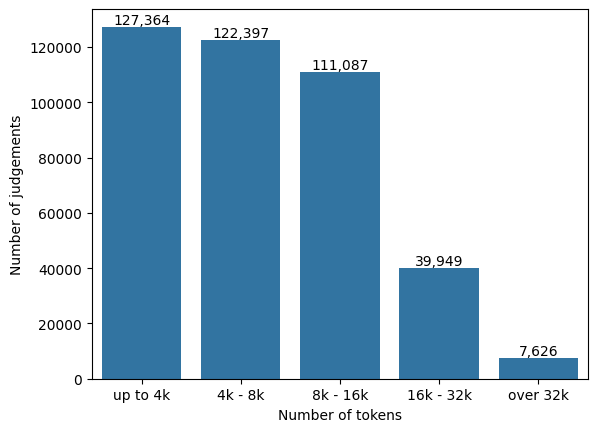

In [28]:
ax = sns.countplot(
    data=judgements_num_tokens_df,
    x="NumTokensGroup",
    order=["up to 4k", "4k - 8k", "8k - 16k", "16k - 32k", "over 32k"],
)
ax.bar_label(ax.containers[0], fmt="{:,.0f}")
plt.xlabel("Number of tokens")
plt.ylabel("Number of judgements")
plt.show()